In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [114]:
prefix = "sub_"
res_dict = np.load(f"./errors/{prefix}res_for_plots.npy", allow_pickle=True).item()

In [123]:
def table_errors(res_dict):
    for key in res_dict.keys():
        if "70b" in key:
            continue
        measures = ["mse", "acc", "mse_abs", "acc_abs"]
        table = [["ctx","mse", "acc", "mse_abs", "acc_abs"]]
        for opt in res_dict[key].keys():
            line = [opt]
            for measure in measures:
                val = res_dict[key][opt][measure]
                line.append(val)
            table.append(line)
    df = pd.DataFrame(table[1:], columns=table[0])
    return df

prefix = "add_"
res_dict = np.load(f"./errors/{prefix}res_for_plots.npy", allow_pickle=True).item()
add_table = table_errors(res_dict)

prefix = "sub_"
res_dict = np.load(f"./errors/{prefix}res_for_plots.npy", allow_pickle=True).item()
sub_table = table_errors(res_dict)

In [124]:


# Convert the table to a pandas DataFrame
df = pd.DataFrame(table[1:], columns=table[0])
print(df)

   ctx          mse     acc     mse_abs  acc_abs
0  add  194900.9340  0.7050  36143.5500   0.8150
1  sub  176727.0470  0.6360  13307.1430   0.8565
2  mul  198963.2535  0.6385  18566.7735   0.8245
3  div  110154.0960  0.7560  10326.5760   0.8945


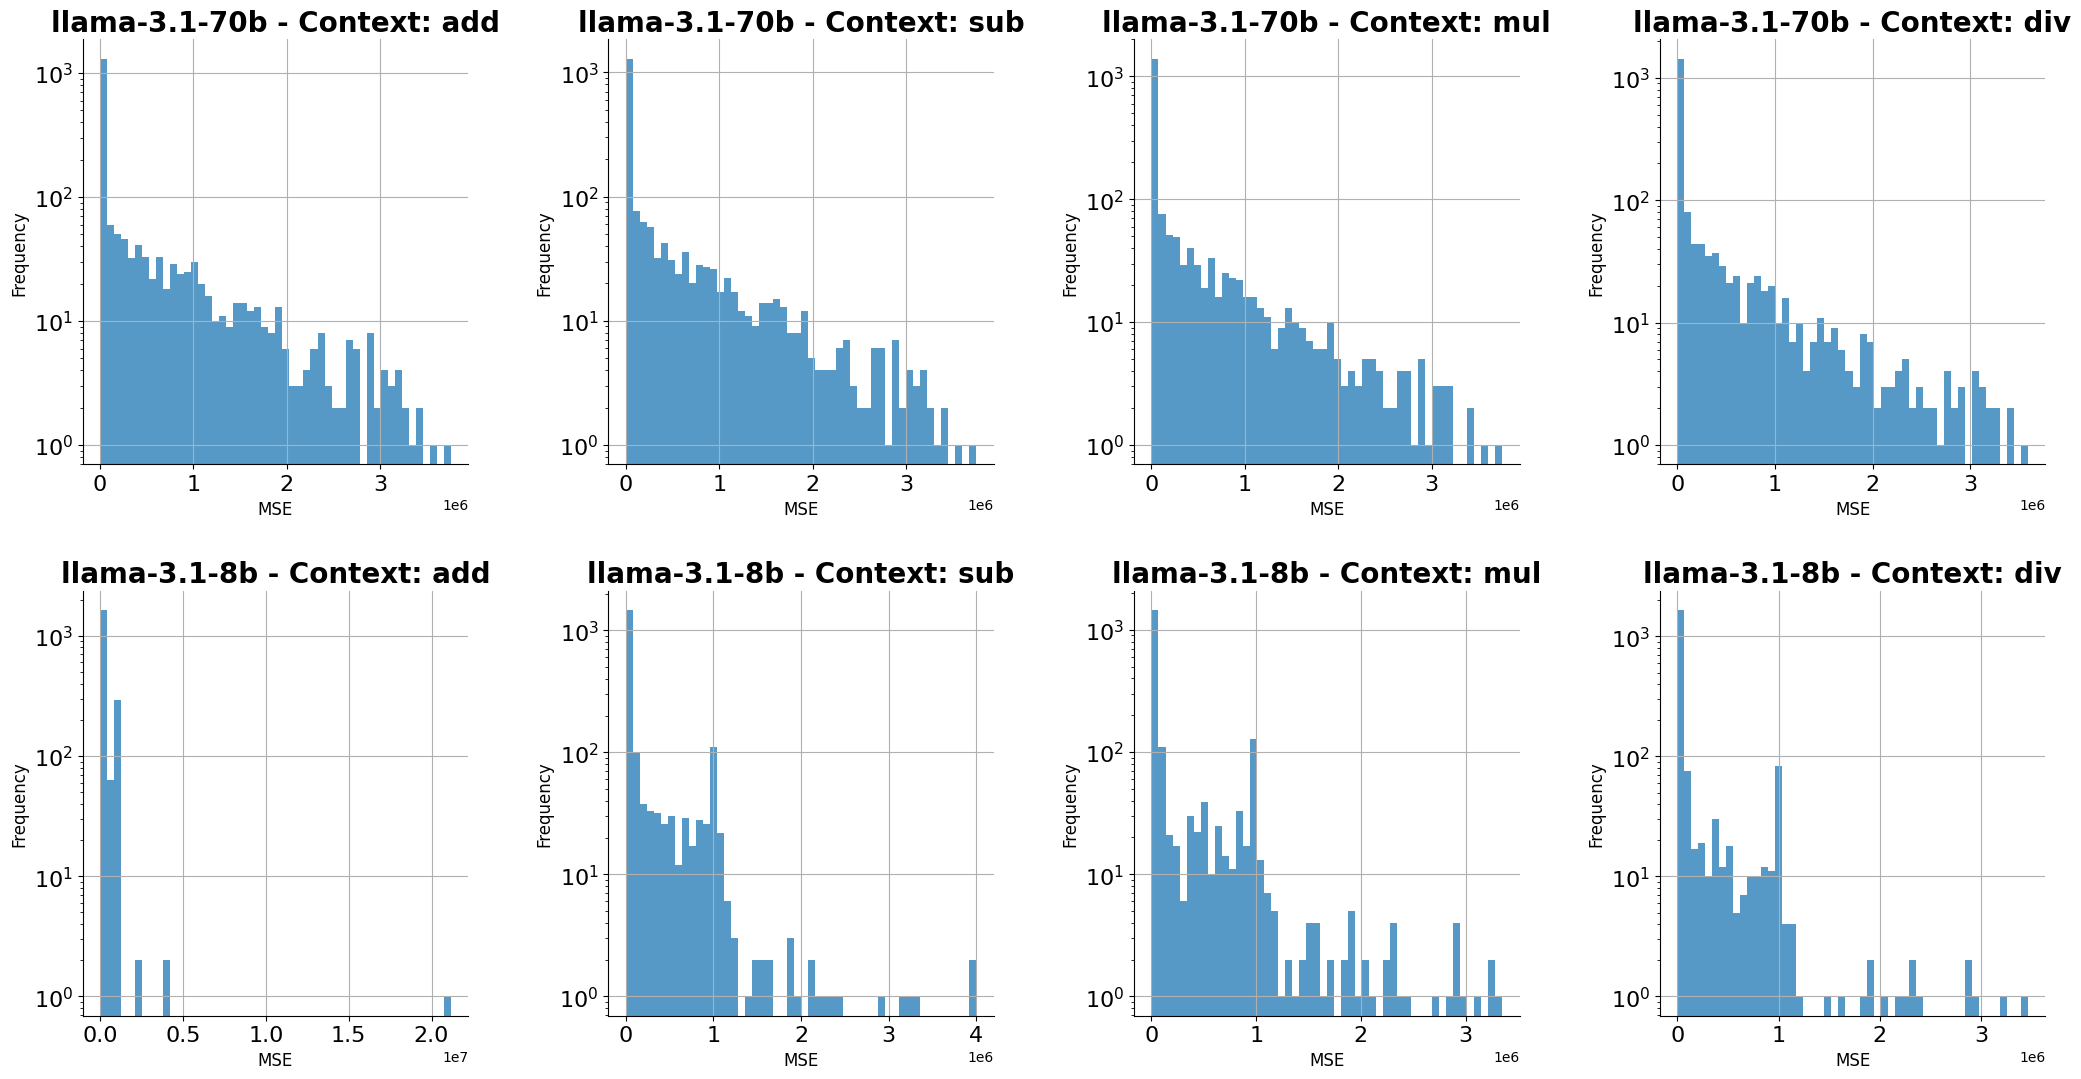

In [94]:
fig, axes = plt.subplots(2,4, figsize=(22, 12))
fig.tight_layout(pad=7.0)

models = list(res_dict.item().keys())
operations = list(res_dict.item()[models[0]].keys())

for i, model in enumerate(models):
    for j, operation in enumerate(operations):
        ax = axes[i, j]

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True)
        ax.set_yscale('log')

        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=16)

        ax.set_title(f'{model} - Context: {operation}', fontsize=20, fontweight='bold')
        ax.set_xlabel('MSE', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'{model} - Context: {operation}', fontsize=20, fontweight='bold')
        ax.set_xlabel('MSE', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

        data = res_dict.item()[model][operation]['diff']
        ax.hist(data, bins=50, alpha=0.75)


plt.show()

fig.savefig(f'{prefix}dist.png', bbox_inches='tight')


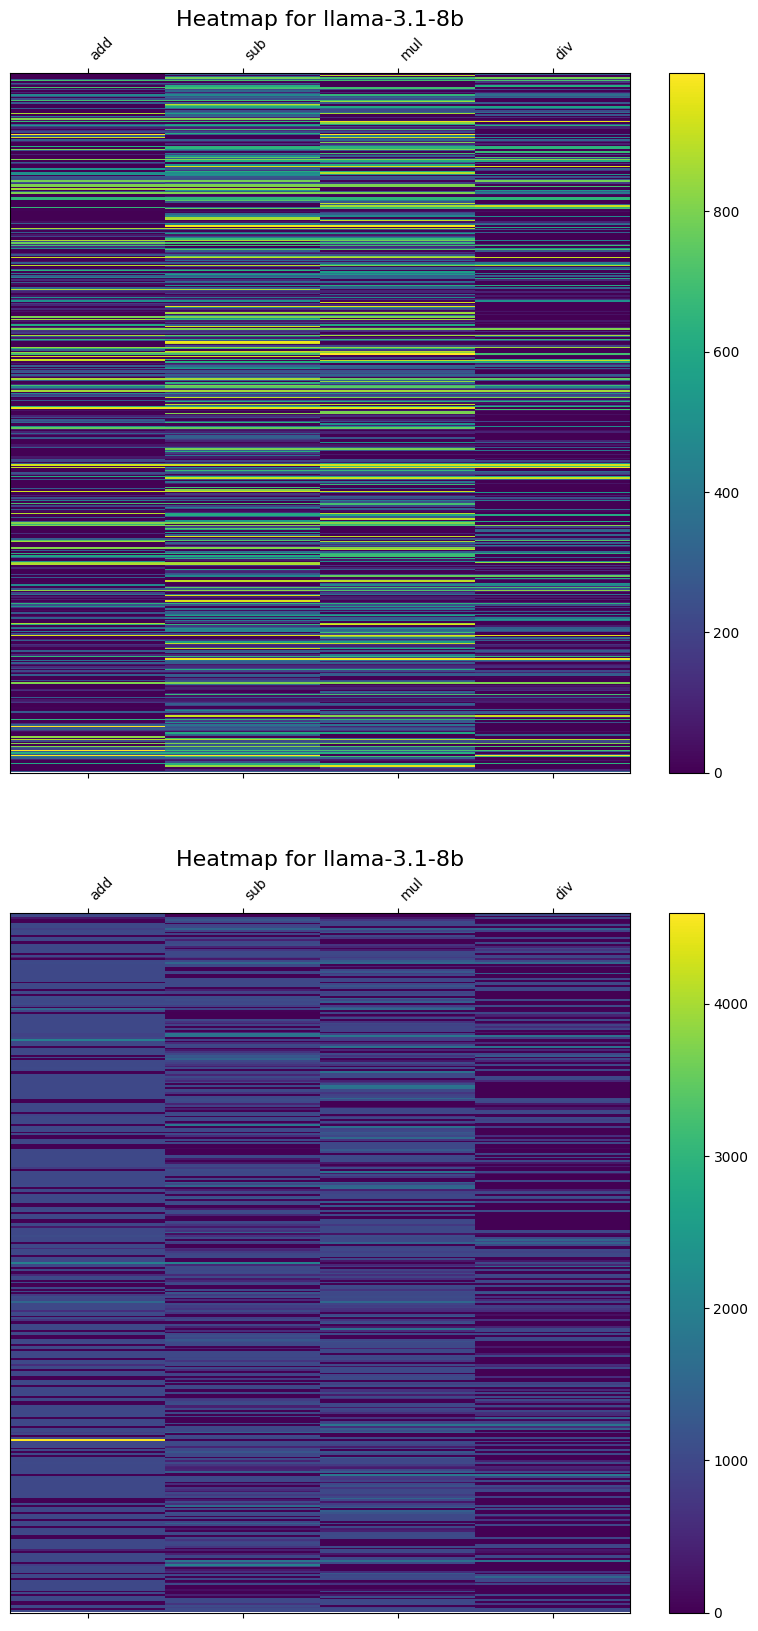

In [95]:
fig, axes = plt.subplots(2,1, figsize=(10, 20))
for i, model in enumerate(models):
    if "70b" in model:
        continue
    heat_map = []
    for j, operation in enumerate(operations):
        data = np.sqrt(res_dict.item()[model][operation]['diff'])
        heat_map.append(data.reshape(-1,1))
    heat_map = np.concatenate(heat_map,axis=1)
    #heat_map = np.concatenate(heat_map)
    
    
    max_heat_map = np.max(heat_map, axis=1)
    heat_map = heat_map[max_heat_map>0]
    heat_map_copy = heat_map.copy()
    max_heat_map = max_heat_map[max_heat_map>0]
    #order = np.argsort(max_heat_map)
    #heat_map = heat_map[order]
    #max_heat_map = max_heat_map[order]

    split_ind = np.logical_and(0.0<max_heat_map, max_heat_map<1000)
    heat_map_small = heat_map[split_ind]
    heat_map_large = heat_map[~split_ind]

    for i, hm in enumerate([heat_map_small, heat_map_large]):
        ax = axes[i]
        cax = ax.matshow(hm, aspect='auto', cmap='viridis')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Heatmap for {model}', fontsize=16)
        ax.set_xticks(np.arange(len(operations)))
        ax.set_xticklabels(operations, rotation=45, ha='left')
        ax.set_yticks([])


In [96]:
for i, model in enumerate(models):
    if "70b" in model:
        continue
    heat_map = []
    for j, operation in enumerate(operations):
        data = np.sqrt(res_dict.item()[model][operation]['diff'])
        heat_map.append(data.reshape(-1,1))
heat_map = np.concatenate(heat_map,axis=1)
#max_heat_map = np.max(heat_map, axis=1)
#heat_map = heat_map[max_heat_map>0]
outlier = (np.max(heat_map, axis=1)<2000)
heat_map = heat_map[outlier]

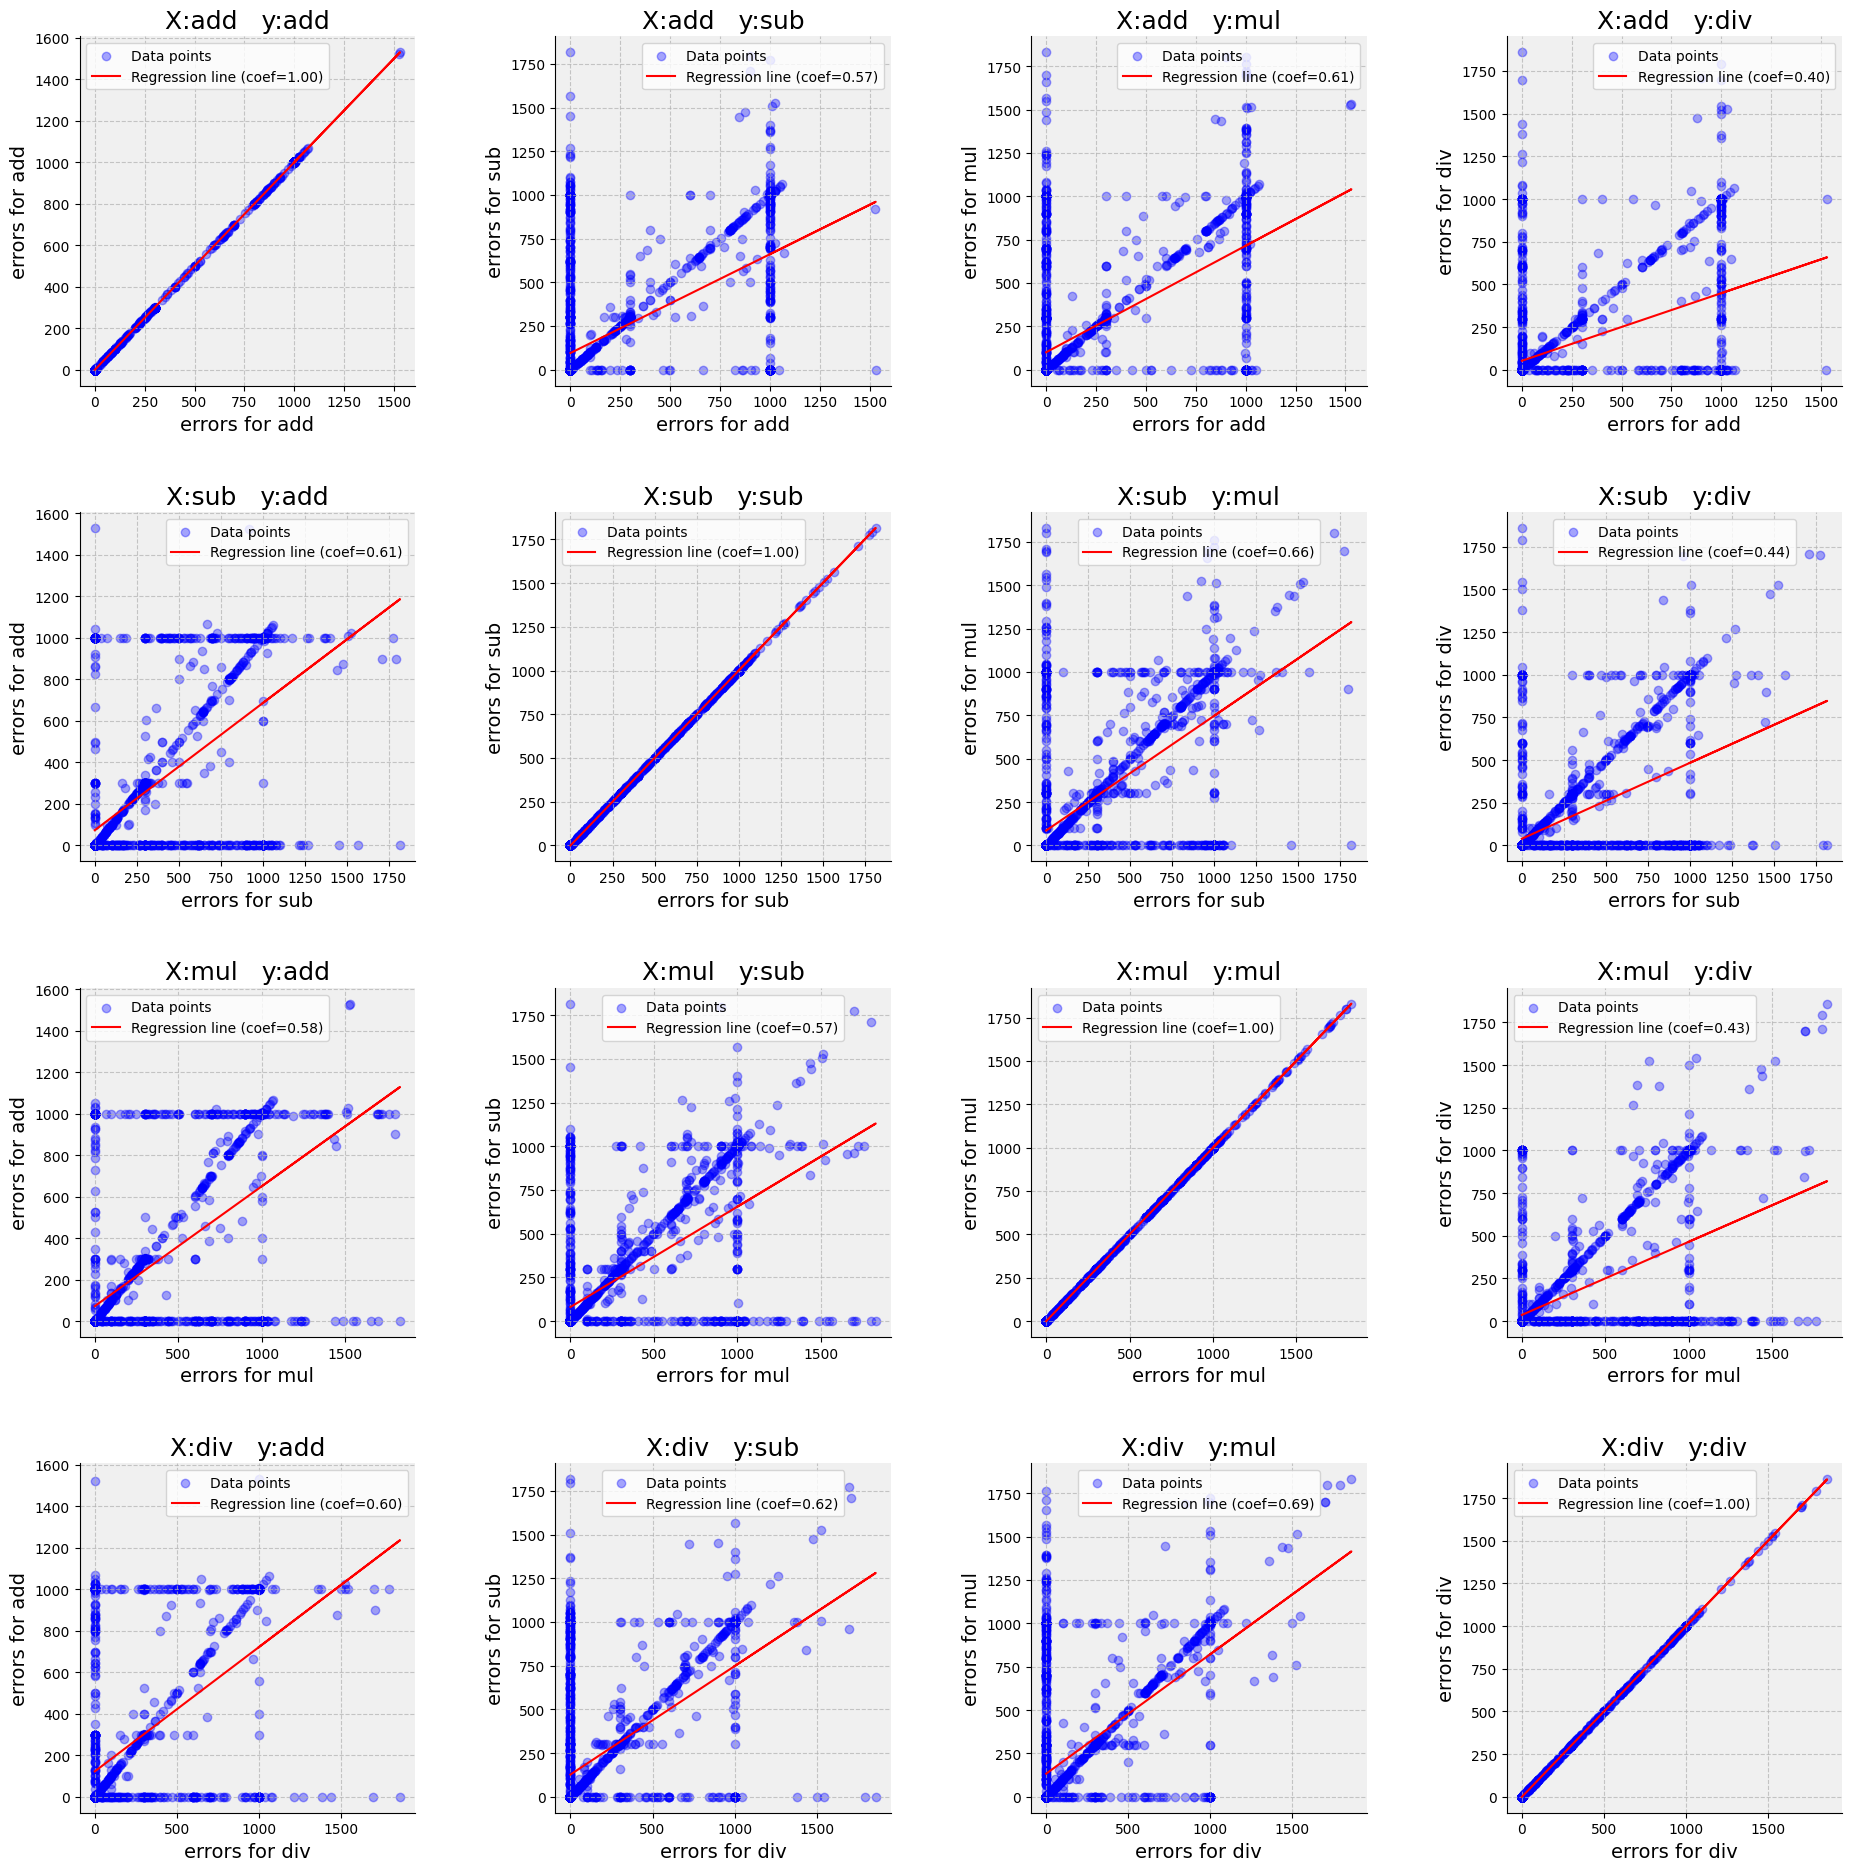

In [97]:
from sklearn.linear_model import LinearRegression
fig, axes = plt.subplots(4,4, figsize=(20, 20))
fig.tight_layout(pad=7.0)
for i, operation1 in enumerate(operations):
    for j, operation2 in enumerate(operations):
        
        ax = axes[i, j]
        X = heat_map[:,i].reshape(-1, 1)
        y = heat_map[:,j]
        
        model = LinearRegression()
        model.fit(X, y)

        predictions = model.predict(X)
        coef = model.coef_[0]
        error = np.mean((predictions - y) ** 2)
        #print(f"Regression coefficient between heat_map_copy[{i}] and heat_map_copy[{j}]: {coef}")
        #print(f"Mean squared error: {error}")
        ax.set_facecolor('#f0f0f0')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, linestyle='--', alpha=0.7)


        ax.scatter(X, y, color='blue', label='Data points', alpha=0.35)
        ax.plot(X, predictions, color='red', label=f'Regression line (coef={coef:.2f})')

        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.tick_params(axis='both', which='minor', labelsize=8)
        ax.set_title(f'X:{operation1}   y:{operation2}', fontsize=18)
        ax.set_xlabel(f'errors for {operation1}', fontsize=14)
        ax.set_ylabel(f'errors for {operation2}', fontsize=14)

        ax.legend()
fig.savefig(f'{prefix}scatter.png', bbox_inches='tight')

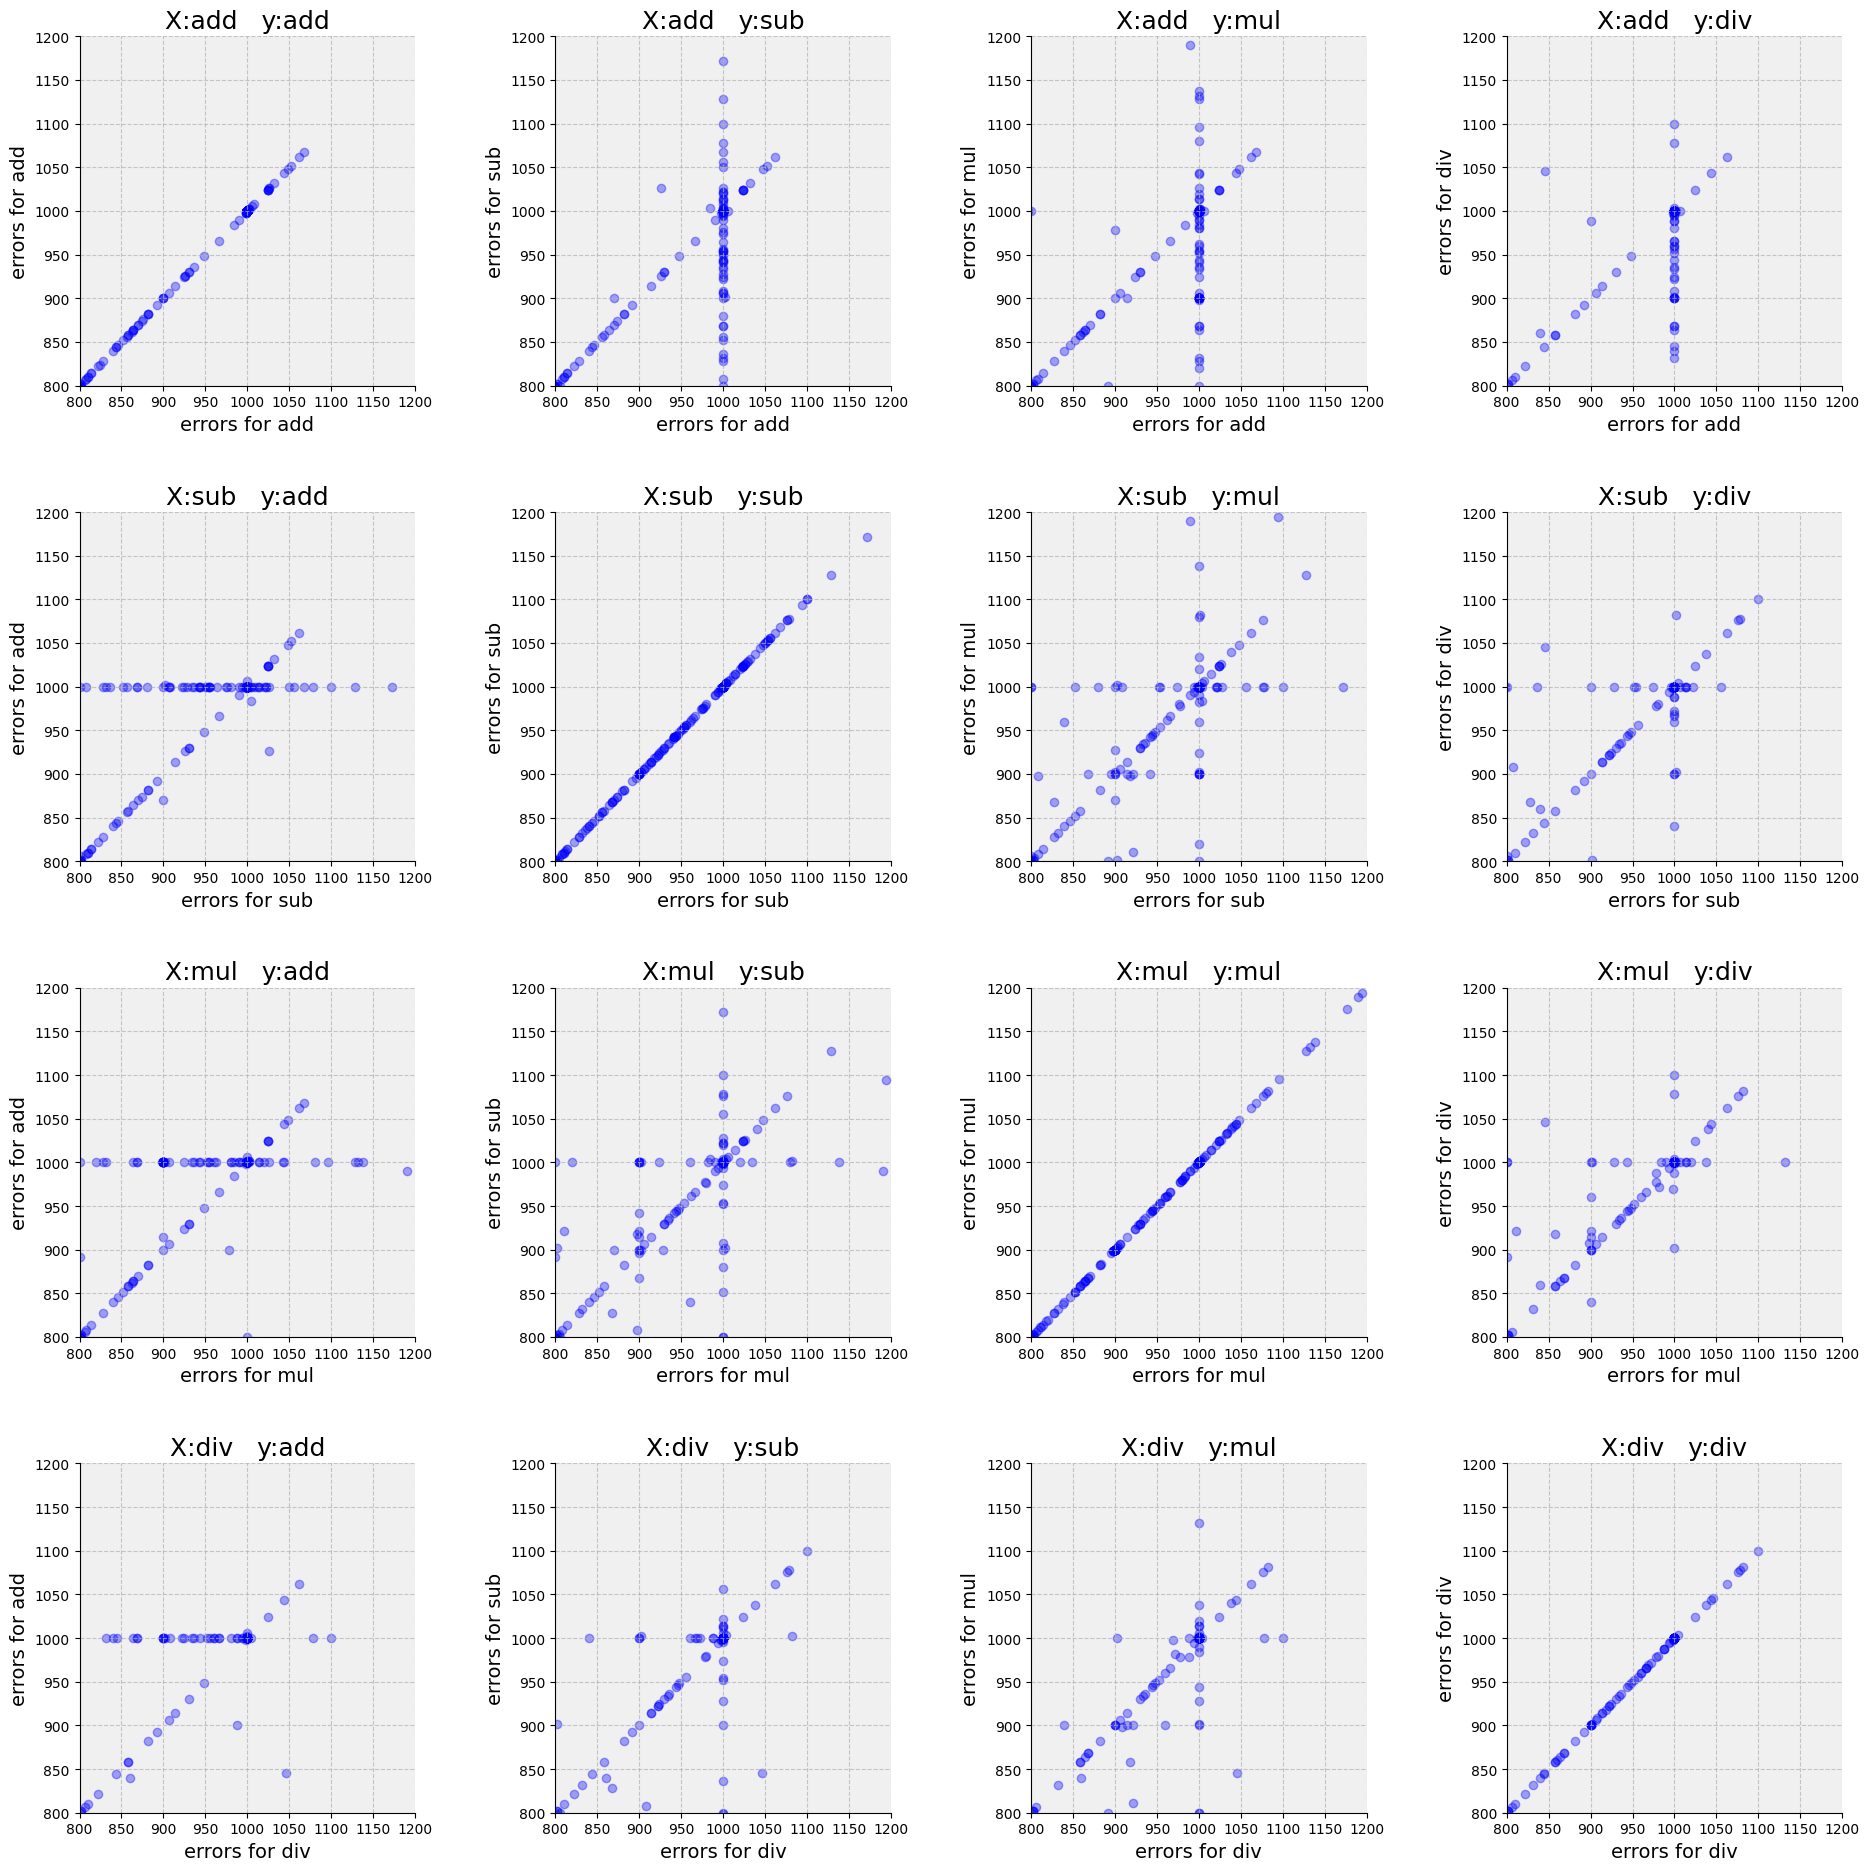

In [98]:
from sklearn.linear_model import LinearRegression
fig, axes = plt.subplots(4,4, figsize=(20, 20))
fig.tight_layout(pad=7.0)
for i, operation1 in enumerate(operations):
    for j, operation2 in enumerate(operations):
        
        ax = axes[i, j]
        X = heat_map[:,i].reshape(-1, 1)
        y = heat_map[:,j]
        
        model = LinearRegression()
        model.fit(X, y)

        predictions = model.predict(X)
        coef = model.coef_[0]
        error = np.mean((predictions - y) ** 2)
        #print(f"Regression coefficient between heat_map_copy[{i}] and heat_map_copy[{j}]: {coef}")
        #print(f"Mean squared error: {error}")
        ax.set_facecolor('#f0f0f0')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, linestyle='--', alpha=0.7)


        ax.scatter(X, y, color='blue', label='Data points', alpha=0.35)
        ax.set_xlim(800, 1200)
        ax.set_ylim(800, 1200)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.tick_params(axis='both', which='minor', labelsize=8)
        ax.set_title(f'X:{operation1}   y:{operation2}', fontsize=18)
        ax.set_xlabel(f'errors for {operation1}', fontsize=14)
        ax.set_ylabel(f'errors for {operation2}', fontsize=14)

fig.savefig('zoom_scatter.png', bbox_inches='tight')

In [99]:
for i, model in enumerate(models):
    if "70b" in model:
        continue
    heat_map = []
    for j, operation in enumerate(operations):
        data = np.sqrt(res_dict.item()[model][operation]['diff'])
        heat_map.append(data.reshape(-1,1))
heat_map = np.concatenate(heat_map,axis=1)
max_heat_map = np.max(heat_map, axis=1)
min_heat_map = np.min(heat_map, axis=1)
#heat_map = heat_map[max_heat_map>0]
ind = np.logical_and(1000.0<max_heat_map, max_heat_map<1500)
ind2 = min_heat_map==0
ind = np.logical_and(ind, ind2)
outlier = (np.max(heat_map, axis=1)<2000)
heat_map_filtered = heat_map[ind]

In [100]:
print(operations)
heat_map_filtered

['add', 'sub', 'mul', 'div']


array([[   0., 1224.,  724.,    0.],
       [   0., 1000., 1034.,    0.],
       [1002.,    0., 1002.,  102.],
       [1000.,    0., 1258.,    0.],
       [1000., 1068.,  700.,    0.],
       [1000.,  950., 1250.,    0.],
       [ 990.,  990., 1190.,    0.],
       [1032., 1032.,    0.,    0.],
       [1000., 1000., 1388.,    0.],
       [1000., 1000., 1380.,    0.],
       [1052., 1052.,    0.,    0.],
       [   0.,    0., 1176.,    0.],
       [   0., 1266.,  666., 1266.],
       [1000., 1172., 1000.,    0.],
       [   0., 1454.,    0.,  900.],
       [1024., 1024., 1024.,    0.],
       [1000.,    0., 1042.,    0.],
       [ 984., 1004.,  984.,    0.],
       [   0., 1076., 1076., 1076.],
       [1000.,    0., 1002., 1000.],
       [   0., 1006., 1006., 1000.],
       [ 926., 1026.,    0.,    0.],
       [1000., 1022., 1000.,    0.],
       [   0.,    0., 1252.,    0.],
       [1000., 1000., 1138.,    0.],
       [   0.,    0., 1002.,    0.],
       [   0.,  102., 1002.,  102.],
 

In [101]:
ex1 = np.array([[1000.,    0., 1002., 1000.]])
'''
 prompt: "### 492 - 493 = answer{-1} ### <eop>\n### 655 - 903 = answer{-248} ### <eop>\n### 453 - 134 = answer{319} ### <eop>\n### 358 - 236 = answer{122} ### <eop>\n### 432 - 723 = answer{-291} ### <eop>\n### 128 - 769 = answer{",
 gt: -641
 answers for conexts:
    add: 359
    sub: -641
    mul: 361
    div: 359

'''

ex2 = np.array([[  0., 1056.,    0.,    0.]])
'''
 prompt: "### 496 - 648 = answer{-152} ### <eop>\n### 468 - 697 = answer{-229} ### <eop>\n### 143 - 996 = answer{-853} ### <eop>\n### 353 - 775 = answer{-422} ### <eop>\n### 998 - 736 = answer{262} ### <eop>\n### 197 - 674 = answer{",
 gt: -641
 answers for conexts:
    add: 0
    sub: -477
    mul: 0
    div: 0

'''

'\n prompt: "### 496 - 648 = answer{-152} ### <eop>\n### 468 - 697 = answer{-229} ### <eop>\n### 143 - 996 = answer{-853} ### <eop>\n### 353 - 775 = answer{-422} ### <eop>\n### 998 - 736 = answer{262} ### <eop>\n### 197 - 674 = answer{",\n gt: -641\n answers for conexts:\n    add: 0\n    sub: -477\n    mul: 0\n    div: 0\n\n'

In [102]:
np.where((heat_map==ex2).sum(axis=1)==4)


(array([710]),)

In [103]:
"query_prompt":  "gold_answer": -641, "generated_ans": -641,


SyntaxError: illegal target for annotation (305249363.py, line 1)